# Notebook to run gPhoton
Run gPhoton to create GALEX light curves etc.
Setup your source parameter and setting in the cell below.

In [1]:
region_name = "ALL_10-800_LOOSE" 
outdir = "./resources/gPhoton_out/"
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"

srcs_ids = [4993 ,13580 ,14504 ,30475 ,50388 ,52994 ,79477 ,120265 ,138783 ,139480 ,162697 ,204419 ,221349 ,228958 ,236839 ,253214 ,253670
            ,256433 ,261213 ,331466 ,340464 ,381336 ,390864 ,489430 ,498065 ,525310 ,532554 ,533185 ,540235 ,583838 ,639720 ,645215 ,645730
            ,659787 ,666224 ,673175 ,680119 ,691408 ,714140 ,764827 ,1037284 ,1069077 ,1070938 ,1805505 ,1839206 ,2527679 ,3074917 ,] 
#srcs_ids = [4993]

In [2]:
%matplotlib widget
import ipywidgets as widgets
import gPhoton
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table, join
from astropy import units as uu
import os
from vasca.utils import mag2flux, flux2mag, tgalex_to_astrotime
import vasca.visualization as vvis
from vasca.region import Region
from vasca.resource_manager import ResourceManager

rg = Region()
rg.load_from_fits(region_fname)

#Subselect sources based on choice
if len(srcs_ids)>0:
    rg.tt_sources.add_index("rg_src_id")
    idx_srcs = rg.tt_sources.loc_indices["rg_src_id", srcs_ids]
    tt_srcs = Table(rg.tt_sources[idx_srcs])
else:
    tt_srcs = rg.tt_sources


#display(tt_srcs)

### Do aperture photometry for each visit with gPhoton

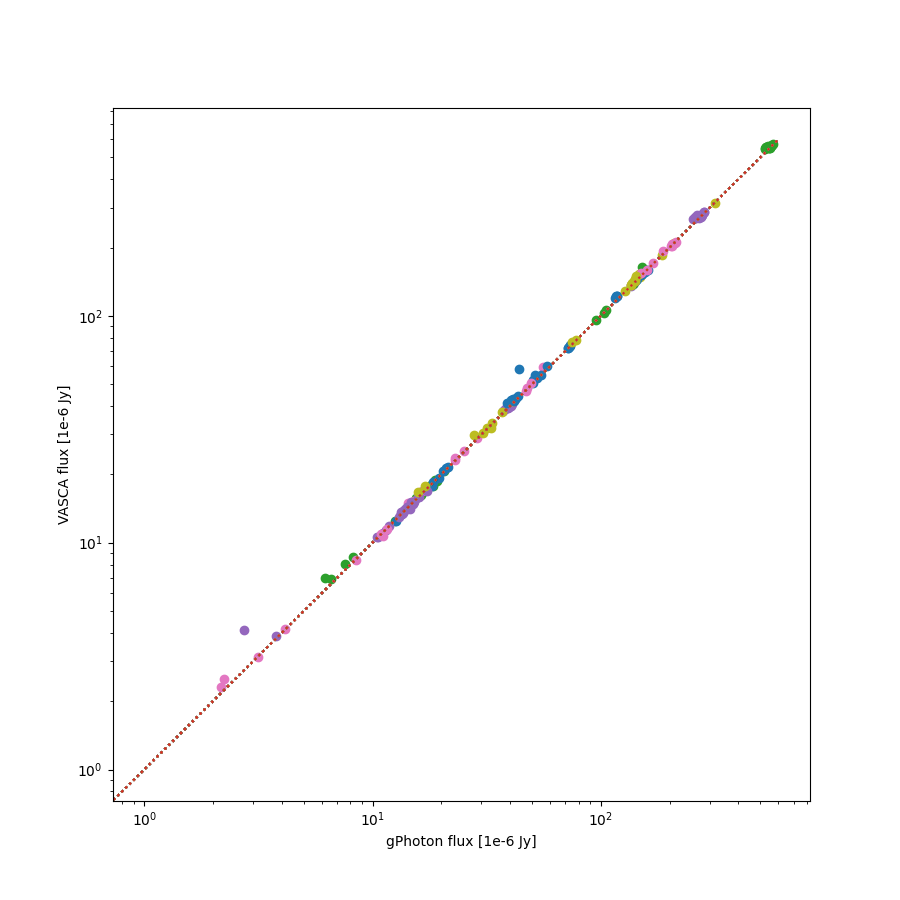

In [3]:
fig, ax = plt.subplots(1,1,figsize=(9, 9), squeeze=True, num="gPhotFlux", clear=True) 

for rg_src_id in srcs_ids:

    #Get source
    tc_src = rg.get_src_from_id(rg_src_id, load_from_file = True, add_sed=False,add_gphoton=True, add_spectrum=False)
    tt_gp_lc = tc_src.tt_gphoton_lc
    tt_gp_lc["rtime"]=np.round(tt_gp_lc["time"],4)
    tt_src_lc = tc_src.tt_source_lc
    tt_src_lc["rtime"]=np.round(tt_src_lc["time"],4)
    tt_lc = join(tt_gp_lc,tt_src_lc,keys=['obs_filter_id',"rtime"],join_type='outer',table_names=["gp","src"]) 
    sel_both = ~tt_lc["time_gp"].mask*~tt_lc["time_src"].mask
    tt_lc_both = tt_lc[sel_both]
    sel_gp = tt_lc_both["sel_gp"]*tt_lc_both["s2n"]>3
    #display(tt_lc[sel_both])
    
    ax.plot(tt_lc_both[sel_gp]["flux_gp"],tt_lc_both[sel_gp]["flux_src"],"o")
    ax.set_xlabel("gPhoton flux [1e-6 Jy]")
    ax.set_ylabel("VASCA flux [1e-6 Jy]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.plot(range(600),range(600),":")
    


In [4]:
# Calculate apperture flux correctin from http://www.galex.caltech.edu/researcher/techdoc-ch5.html
f1 = mag2flux(19)
f2 = mag2flux(19-0.12)
mag = flux2mag(f2)
print(f1,f2,f2/f1, mag)


91.20108393559062 1e-06 Jy 101.8591388054115 1e-06 Jy 1.1168632477805633 18.88 mag(AB)


In [5]:
1/(60*60)

0.0002777777777777778

In [6]:
10/(24*60)

0.006944444444444444